In [1]:
import numpy as np
import glob, os
from keras import layers as ly
from keras.models import Sequential, load_model, Model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.layers import Input, Lambda
from keras import losses
from keras.models import model_from_json
import keras.backend.tensorflow_backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
import string

Using TensorFlow backend.


In [2]:
#dir = './sequence/*'
dir = './latest_sequence/bfs-character/*'

In [3]:
# file read
all_names = []
all_data = []
sequence_length = []
alpha = list(string.ascii_uppercase)
data_length = len(glob.glob(dir))
file_predix = './latest_sequence/bfs-character/graph'
for index in range(data_length):
    filename = file_predix + str(index) + "-*"
    files = glob.glob(filename)
    for file in files:
        datasets = []
        all_names.append(file.split('/')[-1].replace('.txt', ''))
        for rf in open(file, 'r'):
            (u, v, w) = rf[1:-2].split(', ')
            datasets.append([alpha.index(u[1])+1, alpha.index(v[1]) +1, float(w)])
        sequence_length.append(len(datasets))
        all_data.append(datasets)
all_data = np.array([np.array(arr) for arr in all_data])

In [4]:
x_train, x_test, train_name, test_name = train_test_split(all_data, all_names, test_size=0.3)
x_test, x_val, test_name, val_name = train_test_split(x_test, test_name, test_size=0.33)

In [5]:
train_name
tr_names= []
for name in train_name:
    tr_names.append(name.split('-')[0].replace('graph', ''))

In [6]:
max_sequence_length = max(sequence_length)
n_features = 3
batch_size = 32
epochs = 500
steps_per_epoch = len(x_train)

In [7]:
def custom_loss(y_true, y_pred):
    loss1 = losses.mean_squared_error(y_true, y_pred)
    #loss2 = losses.kld(y_true, y_pred)
    return loss1# * 0.7 + loss2 * 0.3

In [8]:
def repeat_vector(args):
    layer_to_repeat = args[0]
    sequence_layer = args[1]
    return RepeatVector(K.shape(sequence_layer)[1])(layer_to_repeat)
    

inputs = Input(shape=(None, 3))
encoded = LSTM(128, return_sequences=True)(inputs)  #activation 안적으면 tanh
encoded = LSTM(64)(encoded)

decoded = Lambda(repeat_vector, output_shape=(None, 64)) ([encoded, inputs]) # inputs의 shape[1] 만큼 encoded 를 반복 생성

decoded = LSTM(64, return_sequences=True)(decoded)
decoded = LSTM(128, return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(3))(decoded)
encoder = Model(inputs, encoded)

lstm_autoencoder = Model(inputs, decoded)
lstm_autoencoder.compile(loss=custom_loss, optimizer=Adam())#lr=1e-2, decay=0.9))
#lstm_autoencoder_500 = lstm_autoencoder

In [9]:
def val_generator(x_val):
    idx = 0
    while True:
        yield np.array([x_val[idx]]), np.array([x_val[idx]])
        idx += 1
        if idx >= len(x_val):
            idx = 0

def train_generator(x_train):
    idx = 0
    while True:
        yield np.array([x_train[idx]]), np.array([x_train[idx]])
        idx += 1
        if idx >= len(x_train):
            idx = 0

In [10]:
hist = lstm_autoencoder.fit_generator(train_generator(x_train), epochs=300, steps_per_epoch=steps_per_epoch, verbose=1, validation_steps=len(x_val), validation_data=val_generator(x_val))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/300
6468/6468 [==============================] - 61s 9ms/step - loss: 37.4117 - val_loss: 19.9987
Epoch 2/300
6468/6468 [==============================] - 60s 9ms/step - loss: 19.3262 - val_loss: 15.7625
Epoch 3/300
6468/6468 [==============================] - 61s 10ms/step - loss: 16.1341 - val_loss: 14.2765
Epoch 4/300
6468/6468 [==============================] - 61s 9ms/step - loss: 13.6860 - val_loss: 11.6974
Epoch 5/300
6468/6468 [==============================] - 61s 9ms/step - loss: 11.2654 - val_loss: 9.9855
Epoch 6/300
6468/6468 [==============================] - 62s 10ms/step - loss: 9.9381 - val_loss: 8.7215
Epoch 7/300
6468/6468 [==============================] - 62s 10ms/step - loss: 9.0315 - val_loss: 8.4828
Epoch 8/300
6468/6468 [==============================] - 61s 9ms/step - loss: 8.1982 - val_loss: 7.9519
Epoch 9/300
6468/6468 [==============================] - 60s

6468/6468 [==============================] - 59s 9ms/step - loss: 0.5799 - val_loss: 0.9560
Epoch 72/300
6468/6468 [==============================] - 59s 9ms/step - loss: 0.5840 - val_loss: 1.0710
Epoch 73/300
6468/6468 [==============================] - 59s 9ms/step - loss: 0.5635 - val_loss: 0.8611
Epoch 74/300
6468/6468 [==============================] - 59s 9ms/step - loss: 0.5552 - val_loss: 0.8368
Epoch 75/300
6468/6468 [==============================] - 59s 9ms/step - loss: 0.5476 - val_loss: 0.8377
Epoch 76/300
6468/6468 [==============================] - 59s 9ms/step - loss: 0.5688 - val_loss: 0.9158
Epoch 77/300
6468/6468 [==============================] - 59s 9ms/step - loss: 0.5294 - val_loss: 0.9590
Epoch 78/300
6468/6468 [==============================] - 59s 9ms/step - loss: 0.5178 - val_loss: 0.9088
Epoch 79/300
6468/6468 [==============================] - 59s 9ms/step - loss: 0.5151 - val_loss: 1.0067
Epoch 80/300
6468/6468 [==============================] - 59s 9ms/st

6468/6468 [==============================] - 59s 9ms/step - loss: 0.3018 - val_loss: 0.6593
Epoch 149/300
6468/6468 [==============================] - 59s 9ms/step - loss: 0.3080 - val_loss: 0.6825
Epoch 150/300
6468/6468 [==============================] - 59s 9ms/step - loss: 0.3067 - val_loss: 0.7174
Epoch 151/300
6468/6468 [==============================] - 59s 9ms/step - loss: 0.3153 - val_loss: 0.6183
Epoch 152/300
6468/6468 [==============================] - 59s 9ms/step - loss: 0.3006 - val_loss: 0.5805
Epoch 153/300
6468/6468 [==============================] - 59s 9ms/step - loss: 0.3034 - val_loss: 0.6789
Epoch 154/300
6468/6468 [==============================] - 59s 9ms/step - loss: 0.2929 - val_loss: 0.6489
Epoch 155/300
6468/6468 [==============================] - 59s 9ms/step - loss: 0.3017 - val_loss: 0.6254
Epoch 156/300
6468/6468 [==============================] - 59s 9ms/step - loss: 0.2918 - val_loss: 0.6136
Epoch 157/300
6468/6468 [==============================] - 6

6468/6468 [==============================] - 59s 9ms/step - loss: 0.2391 - val_loss: 0.6042
Epoch 226/300
6468/6468 [==============================] - 59s 9ms/step - loss: 0.2470 - val_loss: 0.6437
Epoch 227/300
6468/6468 [==============================] - 59s 9ms/step - loss: 0.2366 - val_loss: 0.6230
Epoch 228/300
6468/6468 [==============================] - 59s 9ms/step - loss: 0.2380 - val_loss: 0.6478
Epoch 229/300
6468/6468 [==============================] - 59s 9ms/step - loss: 0.2694 - val_loss: 0.9192
Epoch 230/300
6468/6468 [==============================] - 59s 9ms/step - loss: 0.2418 - val_loss: 0.5771
Epoch 231/300
6468/6468 [==============================] - 59s 9ms/step - loss: 0.2319 - val_loss: 0.6040
Epoch 232/300
6468/6468 [==============================] - 59s 9ms/step - loss: 0.2626 - val_loss: 0.6098
Epoch 233/300
6468/6468 [==============================] - 59s 9ms/step - loss: 0.2353 - val_loss: 0.6165
Epoch 234/300
6468/6468 [==============================] - 5

In [11]:
model_json = lstm_autoencoder.to_json()
filename = 'last_mse_lstmae' # input('filename: ') #
with open('model_save/mse_weights/' + filename + '.json', 'w') as file:
    file.write(model_json)
lstm_autoencoder.save_weights('model_save/mse_weights/weights_' +  filename + '.h5')

In [13]:
import json
with open('model_save/mse_weights/mse_history.json', 'w') as f:
    json.dump(hist.history, f)

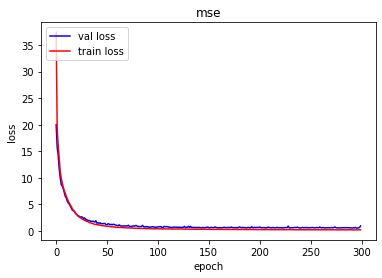

In [19]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['val_loss'], 'b', label='val loss')
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

plt.title('mse')
plt.show()

In [12]:
filename = "last_mse_lstmae"
loaded_model = model_from_json(open('model_save/mse_weights/' +filename + '.json').read())
loaded_model.load_weights('model_save/mse_weights/weights_' + filename + '.h5')

W1010 15:48:40.110543 140189195294464 deprecation_wrapper.py:119] From /home/minji/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1010 15:48:40.120297 140189195294464 deprecation_wrapper.py:119] From /home/minji/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1010 15:48:40.123097 140189195294464 deprecation_wrapper.py:119] From /home/minji/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1010 15:48:40.688915 140189195294464 deprecation_wrapper.py:119] From /home/minji/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



In [14]:
loaded_model = lstm_autoencoder

In [15]:
mean= 0
for xt in x_test:
    xt = xt.reshape(1, xt.shape[0], xt.shape[1])
    out = loaded_model.predict(xt)
    mean += ((xt-out)**2).mean(axis=None)
print(mean/len(x_test))

0.9947123981856851


In [ ]:
encoder = Model(loaded_model.input, loaded_model.layers[3].output)

In [ ]:
test = x_test[0].reshape(1, x_test[0].shape[0], x_test[0].shape[1])
latent_vector = []
for x in x_test:
    x = x.reshape(1, x.shape[0], x.shape[1])
    latent_vector.append(encoder.predict(x)[0])

In [10]:
model_path = 'model_save/mse_weights/weights' + '{epoch:02d}-{loss:.4f}.h5'
early_stopping_callback = EarlyStopping(monitor='loss', patience=200)
checkpoint_callback = ModelCheckpoint(model_path, monitor='loss', verbose = 1, save_best_only = True, save_weights_only = True, mode='min')#, period=5)

In [ ]:
'''def train_generator(x_train):
    idx = 0
    while True:
        leng = len(x_train[idx])
        dt = [x_train[idx]]
        while(leng == len(x_train[idx+1]) and idx < len(x_train)):
            dt += [x_train[idx+1]]
            idx += 1
            if len(dt) >= 100:
                break
        yield np.array(dt), np.array(dt)
        if idx >= len(x_train):
            break
'''